In [138]:
import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor, Resize
from torchvision.datasets import MNIST, CIFAR10, FashionMNIST
from torch.utils.data import Dataset, DataLoader, Subset

import os
from torch.autograd import Variable
from torchvision.utils import save_image
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [139]:
eval_mode = False

In [140]:
class OODDataset(Dataset):
    def __init__(self, dataset, new_label):
        self.dataset = dataset
        self.new_label = new_label

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, _ = self.dataset[idx]  # Ignore the original label
        return img, self.new_label  # Return the image with label=10

In [141]:
# OSR Dataset template
class CombinedDataset(Dataset):
    def __init__(self, mnist, ood, transform_mnist=None, transform_ood=None):
        self.mnist = mnist
        self.ood = ood
        # transforms could be defined either here or when you init each dataset.
        self.transform_mnist = transform_mnist
        self.transform_ood = transform_ood

    def __len__(self):
        # combined length of MNIST and OOD
        return len(self.mnist) + len(self.ood)

    def __getitem__(self, idx):
        if idx < len(self.mnist):
            # if index is within the range of MNIST, return MNIST data and label
            data, label = self.mnist[idx]
            if self.transform_mnist:
                data = self.transform_mnist(data)
            return data, label
        else:
            # if index is beyond the range of MNIST, return OOD data and 10 as label
            data, _ = self.ood[idx - len(self.mnist)]  # adjust index for OOD
            if self.transform_ood:
                data = self.transform_ood(data)
            return data, 10  # OOD label is always 10


In [142]:
# Usaged example
# Load the MNIST and OOD datasets
# Define the transformations
transforms = {'mnist':
                transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize([0.5], [0.5])])
              ,'ood':
                transforms.Compose([
                transforms.ToTensor(),
                transforms.Resize((28, 28)),
                transforms.Grayscale(num_output_channels=1),
                transforms.Normalize([0.5], [0.5])])
             }

mnist_train = MNIST(root='./data', train=True, download=True, transform=transforms['mnist'])
mnist_test= MNIST(root='./data', train=False, download=True, transform=transforms['mnist'])
# Load the FashionMNIST dataset (we will assign it label 10)
fasion = FashionMNIST(root='./data', train=False, download=True, transform=transforms['ood'])
cif = datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms['ood'])

batch_size = 1024

torch.manual_seed(42)
np.random.seed(42)

#Sample 10K images
train_indices = np.random.choice(len(mnist_train), 10000, replace=False)
train_subset = Subset(mnist_train, train_indices)

regular_fashion_loader = DataLoader(fasion, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)

fasion_labeled = OODDataset(fasion, new_label=10)
cif_labeled = OODDataset(cif, new_label=10)

data_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

mnist_test_indices = np.random.choice(len(mnist_test), 2000, replace=False)
mnist_test_subset = Subset(mnist_test, mnist_test_indices)

fasion_indices = np.random.choice(len(fasion_labeled), 2000, replace=False)
fasion_subset = Subset(fasion_labeled, fasion_indices)

cif_indices = np.random.choice(len(cif_labeled), 2000, replace=False)
cif_subset = Subset(cif_labeled, cif_indices)

combined_dataset_fashion = CombinedDataset(mnist_test_subset, fasion_subset)
combined_dataset_cif = CombinedDataset(mnist_test_subset, cif_subset)

fashion_loader = DataLoader(fasion_subset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)

combined_loader_fashion = DataLoader(combined_dataset_fashion, batch_size=batch_size, shuffle=True, num_workers=2)
combined_loader_cif = DataLoader(combined_dataset_cif, batch_size=batch_size, shuffle=True, num_workers=2)

In [143]:
def create_triplets(img, labels, embeddings, device):
    """
    Generate triplet batches (anchor, positive, negative) based on labels.
    """
    anchors, positives, negatives = [], [], []
    unique_labels = labels.unique()
    # iterate over labels (0, ..., 9) for MNIST.
    for label in unique_labels:
        label_mask = labels == label
        non_label_mask = ~label_mask

        # Embeddings for the current class (positives)
        positive_embeddings = embeddings[label_mask]

        # Embeddings for other classes (negatives)
        negative_embeddings = embeddings[non_label_mask]

        for anchor in positive_embeddings:
            positives.append(positive_embeddings[torch.randint(0, len(positive_embeddings), (1,))])
            negatives.append(negative_embeddings[torch.randint(0, len(negative_embeddings), (1,))])
            anchors.append(anchor)

    # Convert to tensors
    anchors = torch.stack(anchors).to(device)
    positives = torch.stack(positives).squeeze().to(device)
    negatives = torch.stack(negatives).squeeze().to(device)
    return anchors, positives, negatives

In [144]:
img_encoded_size = 3

In [145]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        # Encoder network - more flexible with configurable parameters
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),  # (1,28,28) → (16,14,14)
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),  # (16,14,14) → (32,7,7)
            nn.ReLU(),
            nn.Conv2d(32, 64, 5),  # (32,7,7) → (64,3,3)
        )

        # Decoder: Transposed convolutions for upsampling
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 5),  # (64,5,5) → (32,7,7)
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),  # (32,7,7) → (16,14,14)
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),# (32,7,7) → (16,14,14)
            nn.Tanh()
        )

    def forward(self, x):
        z = self.encoder(x)
        reconstructed = self.decoder(z)
        return reconstructed, z


In [146]:
class ML_autoencoder(Autoencoder):
    def __init__(self):
        # inhert from parent
        super().__init__()
        self.n_classes = 10
        #self.hiddenLayers = [64, 128, 64]
        # Add classification head
        self.clf = nn.Sequential(
            nn.Linear(64 * img_encoded_size * img_encoded_size, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, self.n_classes),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        encoded_vector = self.encoder(x)
        recon = self.decoder(encoded_vector)
        preds = self.clf(encoded_vector.view(-1, 64 * img_encoded_size * img_encoded_size))
        return recon, preds, encoded_vector

In [147]:
def get_embeddings(data_loader, model):
    encodings_list = []
    label_list = []
    labels_unique = set()

    model.eval()
    with torch.no_grad():
      for data in data_loader:
          imgs, labels = data
          labels_unique.update(labels.unique().tolist())
          imgs = imgs.to(device)
          labels = labels.to(device)
          _, _, embeddings = model(imgs)

          encodings_list.append(embeddings)
          label_list.append(labels)

    encodings_list = torch.vstack(encodings_list)
    label_list = torch.hstack(label_list)
    return encodings_list, label_list, list(labels_unique)

In [148]:
from torch.nn.functional import pairwise_distance

def train_model(model, criterion, clf_criterion, triplet_loss_fn, optimizer, scheduler, num_epochs=50, trainloader = data_loader, margin = 1):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Lists to hold loss across epochs
    loss_train_ae = []
    loss_train_clf = []
    loss_train_triplet = []

    model.train()
    with tqdm(total=num_epochs, unit="epoch", position=0, leave=True) as pbar:
      img_ = []
      for epoch in range(num_epochs):
          loss_epoch = 0
          loss_ae_epoch = 0
          loss_clf_epoch = 0
          loss_triplet_epoch = 0

          for data in trainloader:
              # Batch loss for updating the model
              loss = 0
              optimizer.zero_grad()
              img, labels = data

              img = img.to(device)
              labels = labels.to(device)

              # Forward pass
              recon, preds, embeddings = model(img)

              if epoch == num_epochs - 1:
                img_.append(img)

              # Reconstruction loss
              loss_ae_batch = criterion(recon, img)
              loss += loss_ae_batch
              loss_ae_epoch += loss_ae_batch.item()

              loss_clf_batch = clf_criterion(preds, labels)
              loss += loss_clf_batch
              loss_clf_epoch += loss_clf_batch.item()

              # Generate triplets based on labels
              img = img.view(img.size(0), -1).to(device)
              anchors, positives, negatives = create_triplets(img, labels, embeddings.view(-1, 64 * img_encoded_size * img_encoded_size), device)
              loss_triplet_batch = triplet_loss_fn(anchors, positives, negatives)
              loss += loss_triplet_batch
              loss_triplet_epoch += loss_triplet_batch.item()

              # Backward pass and optimization
              loss.backward()
              optimizer.step()
              loss_epoch += loss.item()

          # Record losses
          #margin += 1
          #triplet_loss_fn.margin = margin
          loss_train_ae.append(loss_ae_epoch / len(trainloader))
          loss_train_clf.append(loss_clf_epoch / len(trainloader))
          loss_train_triplet.append(loss_triplet_epoch / len(trainloader))
          pbar.set_postfix(
                loss_train_ae=loss_train_ae[-1],
                loss_train_clf=loss_train_clf[-1],
                loss_triplet=loss_train_triplet[-1],

            )
          pbar.update(1)
          scheduler.step()

    img_ = torch.cat(img_, dim=0)

    model.eval()
    plt.figure()
    plt.plot(loss_train_clf, label = "clf loss")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend()
    plt.grid()
    plt.title("clf Training Loss")

    plt.figure()
    plt.plot(loss_train_ae, label="Reconstruction loss")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend()
    plt.grid()
    plt.title("Reconstruction Training Loss")

    plt.figure()
    plt.plot(loss_train_triplet, label="Triplet loss")

    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend()
    plt.grid()
    plt.title("Triplet Training Loss")

    plt.show()
    return model, img_

In [149]:
margin = 1
learning_rate = 0.001

criterion = nn.MSELoss()
clf_criterion = nn.NLLLoss()
triplet_loss_fn = nn.TripletMarginLoss(margin=margin)
model = ML_autoencoder().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.99)

100%|██████████| 90/90 [08:21<00:00,  5.58s/epoch, loss_train_ae=0.027, loss_train_clf=0.00786, loss_triplet=0.0462]


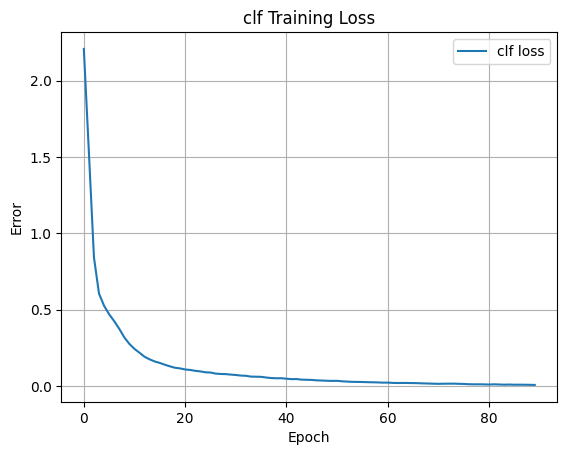

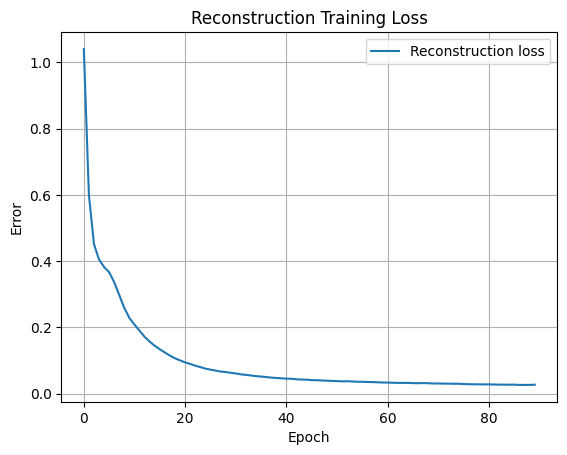

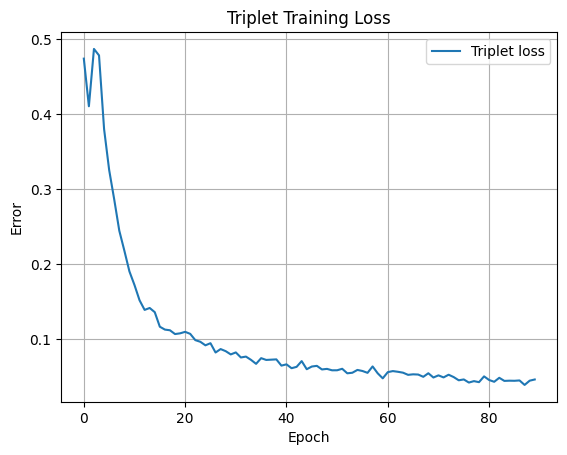

In [150]:
model, imgs = train_model(model, criterion, clf_criterion, triplet_loss_fn, optimizer, scheduler, num_epochs=90)

In [151]:
embeddings, labels, labels_unique = get_embeddings(combined_loader_fashion, model)

<ipython-input-152-26b48bf9182e>:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("tab10", num_classes)


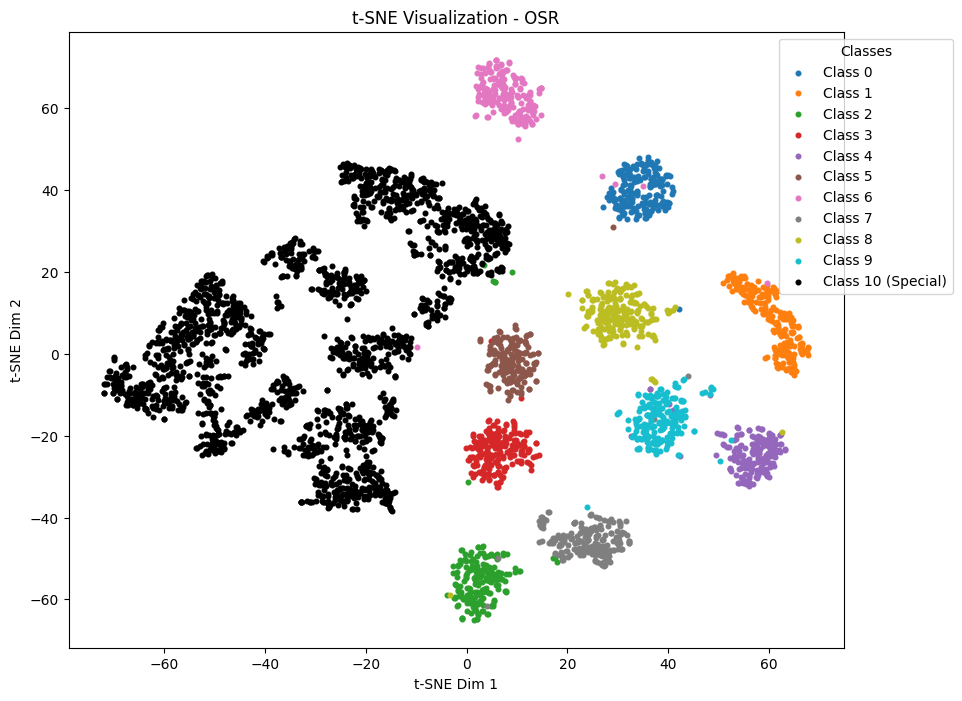

In [152]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import matplotlib.cm as cm

def plot_tsne(embeddings, labels):
    """
    Plots the t-SNE visualization for the embeddings, marking class 10 with X in a different color.

    Args:
        embeddings (numpy.ndarray): The N x Num_features matrix of embeddings.
        labels (numpy.ndarray): The class labels corresponding to the embeddings.
    """
    num_classes = 10  # מחלקות 0-9 יקבלו צבעים רגילים
    special_class = 10  # המחלקה שמסומנת באיקס

    # הגדרת צבעים עבור המחלקות 0-9
    cmap = cm.get_cmap("tab10", num_classes)
    colors = cmap(np.linspace(0, 1, num_classes))

    embeddings = embeddings.detach().cpu().numpy()
    labels = labels.detach().cpu().numpy()
    embeddings = embeddings.reshape(embeddings.shape[0], -1)

    # הרצת t-SNE
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    reduced = tsne.fit_transform(embeddings)

    # יצירת גרף
    plt.figure(figsize=(10, 8))

    # ציור המחלקות 0-9 עם צבעים שונים
    for i in range(num_classes):
        mask = labels == i
        plt.scatter(reduced[mask, 0], reduced[mask, 1], color=colors[i], label=f'Class {i}', s=11)

    # ציור המחלקה 10 עם איקסים בצבע שחור
    mask_special = labels == special_class
    plt.scatter(reduced[mask_special, 0], reduced[mask_special, 1], color='black', label='Class 10 (Special)', s=11)

    # הוספת מקרא
    plt.legend(title="Classes", loc="upper right", bbox_to_anchor=(1.15, 1))

    # כותרות
    plt.title('t-SNE Visualization - OSR')
    plt.xlabel('t-SNE Dim 1')
    plt.ylabel('t-SNE Dim 2')

    # הצגת הגרף
    plt.show()

plot_tsne(embeddings, labels)

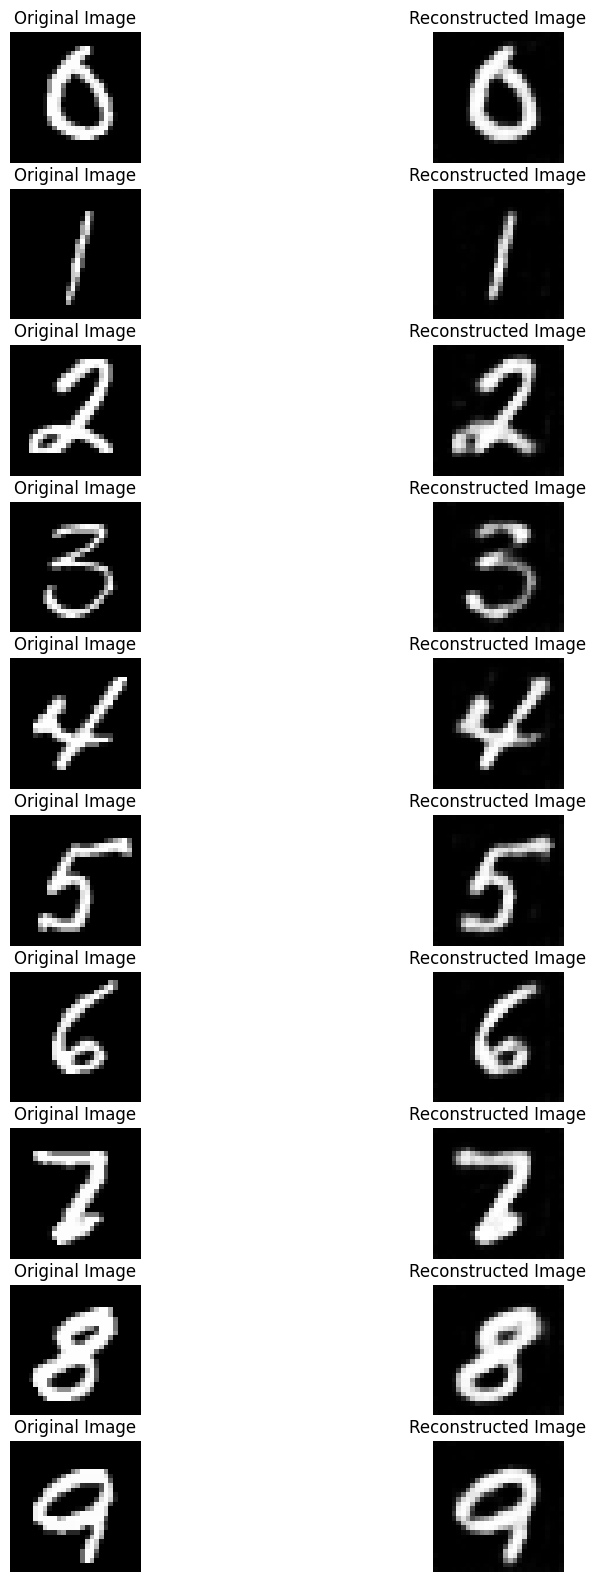

In [153]:
def plot_results(model, test_loader):
    dataiter = iter(test_loader)
    elements, labels = next(dataiter)

    unique_labels = labels.unique()
    n_samples = len(unique_labels)
    uniqueElements = torch.zeros((n_samples, *elements.shape[1:]), dtype=elements.dtype)
    for i, label in enumerate(unique_labels):
        uniqueElements[i] = elements[labels == label][0]

    elements = uniqueElements

    elements = elements.to("cuda")

    model.eval()
    with torch.no_grad():
        recon, preds, embeddings = model(elements)
        Reconstructed_elements = recon.detach().cpu().numpy()

    elements = elements.detach().cpu().numpy()

    fig, axes = plt.subplots(n_samples, 2, figsize=(10, 2*n_samples))
    for i in range(n_samples):

        axes[i, 0].imshow(elements[i].squeeze(), cmap='gray')
        axes[i, 0].set_title('Original Image')
        axes[i, 0].axis('off')

        axes[i, 1].imshow(Reconstructed_elements[i].squeeze(), cmap='gray')
        axes[i, 1].set_title('Reconstructed Image')
        axes[i, 1].axis('off')

    plt.show()

plot_results(model, data_loader)

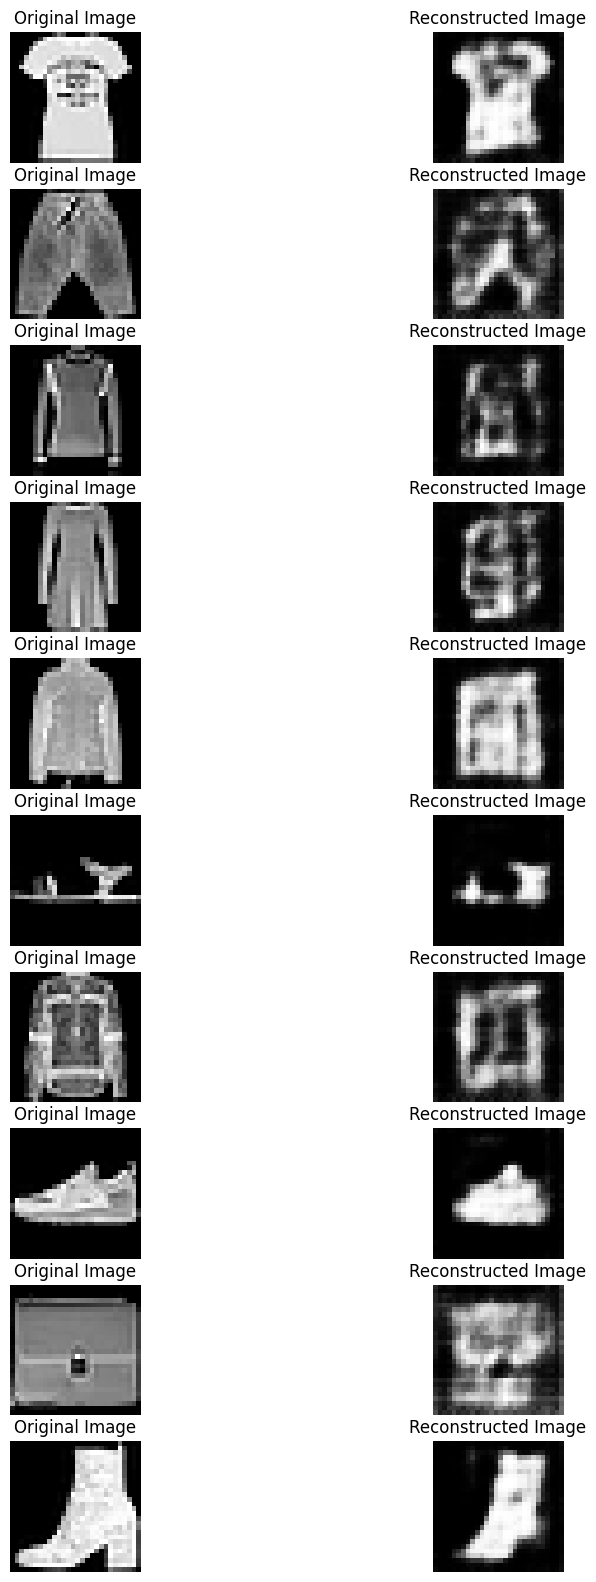

In [154]:
plot_results(model, regular_fashion_loader)

In [155]:
def compute_accuracy(model, testloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testloader:

            labels = labels.to("cuda")
            images = images.to("cuda")

            recon, preds, embeddings = model(images)

            #print(f"labels: {labels}")
            _, predicted = torch.max(preds.data, 1)
            #print(f"predicted: {predicted}")

            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy

compute_accuracy(model, test_loader)

97.54

In [156]:
def compute_centroids_and_radii(embeddings, labels, percentile=99):
    unique_labels = torch.unique(labels)
    centroids = {}
    radii = {}

    for label in unique_labels:
        mask = labels == label
        cluster_points = embeddings[mask].reshape(embeddings[mask].shape[0], -1)

        # Compute centroid
        centroid = cluster_points.mean(dim=0)

        # Compute distances - use cosine distance for high dimensions
        # This often works better than Euclidean in high-dimensional spaces
        distances = torch.norm(cluster_points - centroid, dim=1)  # Compute distances from centroid

        trimmed_points = cluster_points[distances <= distances.quantile(99.5 / 100)]
        centroid = trimmed_points.mean(dim=0)

        distances = torch.norm(trimmed_points - centroid, dim=1)  # Compute distances from centroid

        # Set radius as the specified percentile of distances
        radius = torch.quantile(distances, percentile/100).item()

        centroids[label.item()] = centroid
        radii[label.item()] = radius

    return centroids, radii

In [157]:
def compute_treshold(org_img, reconstructed, percentile=99):
    loss = F.mse_loss(org_img, reconstructed, reduction='none')
    loss = loss.view(loss.shape[0], -1).mean(dim=1)
    threshold = torch.quantile(loss, percentile / 100.0)
    return threshold

In [158]:
class OSR_model(nn.Module):
    def __init__(self, base_model, radii, centroids, threshold):
        super(OSR_model, self).__init__()
        self.base_model = base_model
        self.radii = radii
        self.centroids = centroids
        self.threshold = threshold


    def forward(self, x):
      recon, outputs, embeddings = self.base_model(x)  # Unpack model outputs
      _, preds = torch.max(outputs, 1)

      reconstruction_errors = F.mse_loss(x, recon, reduction='none')  # Compute pixel-wise error
      reconstruction_errors = reconstruction_errors.view(reconstruction_errors.shape[0], -1).mean(dim=1)  # Mean per image

      embeddings = embeddings.reshape(embeddings.shape[0], -1)
      # Initialize predictions with OOD label (10)
      predicted_labels = torch.full((x.shape[0],), 10, dtype=torch.long, device=x.device)

      sorted_keys = sorted(self.centroids.keys())
      centroids = torch.stack([self.centroids[k] for k in sorted_keys]).to(x.device)
      dists = torch.cdist(embeddings, centroids, p=2)

      radii_tensor = torch.tensor([self.radii[k] for k in sorted_keys], device=x.device)
      radii_matrix = radii_tensor.unsqueeze(0).expand(dists.size(0), -1)

      within_any_radius = (dists <= radii_tensor).any(dim=1)
      predicted_labels = torch.where(within_any_radius & (reconstruction_errors <= self.threshold), preds, predicted_labels)

      return predicted_labels

    def get_base_model(self):
      return self.base_model

    def get_centroids(self):
      return self.centroids

In [159]:
if(eval_mode==False):
  embeddings, labels, labels_unique = get_embeddings(data_loader, model)
  centroids, radii = compute_centroids_and_radii(embeddings, labels, percentile = 99)
  recon, _, _ = model(imgs)
  threshold = compute_treshold(imgs, recon, percentile=99.25)
  osr_model = OSR_model(model, radii, centroids, threshold)
  torch.save(osr_model, "OSR_model.pth")
else:
  osr_model = torch.load("model.pth")
  osr_model.eval()

In [160]:
def eval_model(model, data_loader, device):
    """ Evaluation function for the OSR task.
    Given your OSR predictions, comptues the accuracy on MNIST, OOD set and both.
    Note - this function does NOT computes the MNIST baseline accruacy.
    Returns:
     - acc_mnist
     - acc_ood
     - acc_total
    """

    # Ensure model is in evaluation mode
    model.eval()

    correct_mnist = 0
    total_mnist = 0
    correct_ood = 0
    total_ood = 0

    # No need to track gradients for evaluation, saves memory and computations
    with torch.no_grad():
        for data, labels in data_loader:
            data, labels = data.to(device), labels.to(device)

            # Model outputs
            y_pred = model(data)

            # Split MNIST and OOD predictions and labels
            # Assuming numerical labels, which is MNIST/CIFAR datasets default
            # Note: Not one-hot!
            mask_mnist = labels < 10
            mask_ood = ~mask_mnist
            labels_mnist = labels[mask_mnist]
            labels_ood = labels[mask_ood]

            pred_mnist = y_pred[mask_mnist]
            pred_ood = y_pred[mask_ood]

            total_mnist += labels_mnist.size(0)
            total_ood += labels_ood.size(0)
            correct_mnist += (pred_mnist == labels_mnist).sum().item()
            correct_ood += (pred_ood == labels_ood).sum().item()

    acc_mnist = correct_mnist / total_mnist
    acc_ood = correct_ood / total_ood
    acc_total = (correct_mnist + correct_ood) / (total_mnist + total_ood)

    return acc_mnist, acc_ood, acc_total

In [161]:
acc_mnist, acc_ood, acc_total = eval_model(osr_model, combined_loader_fashion, device)
print(f'MNIST Accuracy: {acc_mnist*100:.2f}%')
print(f'OOD Accuracy: {acc_ood*100:.2f}%')
print(f'Total Accuracy: {acc_total*100:.2f}%')

MNIST Accuracy: 96.30%
OOD Accuracy: 99.15%
Total Accuracy: 97.72%


In [162]:
acc_mnist, acc_ood, acc_total = eval_model(osr_model, combined_loader_cif, device)
print(f'MNIST Accuracy: {acc_mnist*100:.2f}%')
print(f'OOD Accuracy: {acc_ood*100:.2f}%')
print(f'Total Accuracy: {acc_total*100:.2f}%')

MNIST Accuracy: 96.30%
OOD Accuracy: 99.90%
Total Accuracy: 98.10%
